In [8]:
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm 
import matplotlib.animation as anim
import os.path as path
import wget

Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 196, in process
    func(*args, **kwargs)
  File "C:\Users\HP\anaconda3\lib\site-packages\matplotlib\animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [88]:
class Particle():
    
    # init
    def __init__(self, r0,v0,a0,t,m,radius,Id):
        
        self.dt  = t[1] - t[0]
        
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        self.rVector = np.zeros( (len(t),len(r0)) )
        self.vVector = np.zeros( (len(t),len(v0)) )
        self.aVector = np.zeros( (len(t),len(a0)) )
               
        self.KVector = np.zeros( (len(t),1) )
        self.UVector = np.zeros( (len(t),1) )
        #self.MVector = np.zeros( (len(t),1) )
        
        self.U = 0. 
        #self.K = 0.
        #self.M = self.U + self.K
        self.F = self.m*self.a
        
        
    # Method
    def Evolution(self,i):
        
        self.SetPosition(i,self.r)
        self.SetVelocity(i,self.v)
        self.SetKinetic(i, self.GetK())
        self.SetPotential(i, self.GetU())
        
        #self.SetMecanic(i, self.M)
        self.a = self.F/self.m
        
        
        # Euler method
        self.r += self.dt * self.v
        self.v += self.dt * self.a
    
    def CheckWallLimits(self,limits,dim=2):
        
        for i in range(dim):
            
            if self.r[i] + self.radius > limits[i]:
                self.v[i] = - self.v[i]
            if self.r[i] - self.radius < - limits[i]:
                self.v[i] = - self.v[i]
    
   
    def Reset(self):
        self.F[:]=0.
        self.U= 0.
        self.a[:] = 0.
    
    def SetPosition(self,i,r):
        self.rVector[i] = r
        
    def SetVelocity(self,i,v):
        self.vVector[i] = v
        
    def SetKinetic(self, i, K):
        self.KVector[i] = K
        
    def SetPotential(self, i, U):
        self.UVector[i] = U
        
    #def SetMecanic(self, i, M):
     #   self.MVector[i] = M
    def Force(self, p2,  k=100, dim=2):
        
        vd = self.r - p2.GetPositionVector() 
        d = np.linalg.norm(vd)
        c = self.radius+p2.GetR() - d
        if c > 0:         
            self.F = np.add(self.F, k*(c**3)*vd/d)
            print(self.F)
            self.U += (k*c**4)/4
    
        
    # Getters  
    
    def GetPositionVector(self):
        return self.rVector
    
    def GetRPositionVector(self):
        return self.RrVector 
    

    def GetVelocityVector(self):
        return self.vVector
    
    def GetRVelocityVector(self):
        return self.RvVector
    
    def GetR(self):
        return self.radius
    
    def GetK(self):
        
        return 0.5*self.m*(self.v[0]**2 + self.v[1]**2)
    
    def GetU(self):
        return self.U
    
    #def GetM(self):
        return self.M
    
    def ReduceSize(self,factor):
        
        self.RrVector = np.array([self.rVector[0]]) # initial condition
        
        
        for i in range(1,len(self.rVector)):
            if i%factor == 0:
                self.RrVector = np.vstack([self.RrVector,self.rVector[i]])
                
               # print(self.RrVector)
    def ReduceVel(self,factor):
        
        self.RvVector = np.array([self.vVector[0]])
        
        for i in range(1,len(self.vVector)):
            if i%factor == 0:
                self.RvVector = np.vstack([self.RvVector,self.vVector[i]])

In [89]:
# Discretization

dt = 0.001
tmax = 10
t = np.arange(0,tmax,dt)

def GetParticles(Limit, dt):
    
    Particles_ = []
    
    p1x0 = np.array([-10.,0.])
    p1v0 = np.array([20.,0.])
    p1a0 = np.array([0.,0.])
    p1 = Particle(p1x0, p1v0, p1a0, t, 1, 2.0, 1)
    Particles_.append(p1)
    
    p2x0 = np.array([0.,-1.6])
    p2v0 = np.array([0.,0.])
    p2a0 = np.array([0.,0.])
    p2 = Particle(p2x0, p2v0, p2a0, t, 1, 2.0, 0)    
    Particles_.append(p2)
    
    p3x0 = np.array([-15.,-15.])
    p3v0 = np.array([0.,0.])
    p3a0 = np.array([0.,0.])
    p3 = Particle(p3x0, p3v0, p3a0, t, 1, 2.0, 0)
    Particles_.append(p3)
        
    return Particles_
Limits = np.array([20,20])


In [90]:
def RunSimulation(t):
    
    Particles = GetParticles(Limits[0],dt=dt)
    
    for it in tqdm(range(len(t))): # Evolucion temporal
        for i in range(len(Particles)):            
            for j in range(len(Particles)):
                if (i != j):
                    Particles[i].Force(Particles[j])
        for i in range(len(Particles)):           
            Particles[i].Evolution(it) 
            Particles[i].Reset()
            Particles[i].CheckWallLimits(Limits)           
        
    return Particles

Particles = RunSimulation(t)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:17<00:00, 559.71it/s]


In [91]:
def ReduceTime(t,factor):
    
    for p in Particles:
        p.ReduceSize(factor)
        p.ReduceVel(factor)
        
    Newt = []
    
    for i in range(len(t)):
        if i%factor == 0:
            Newt.append(t[i])
            
    return np.array(Newt)

<IPython.core.display.Javascript object>


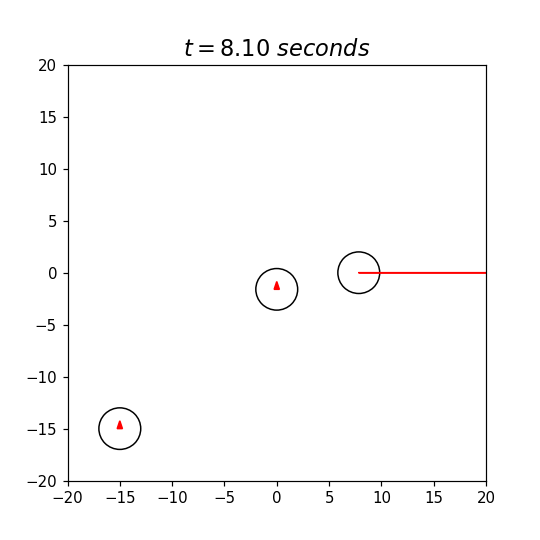

In [92]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

redt = ReduceTime(t,100)

def init():
    ax.set_xlim(-Limits[0],Limits[0])
    ax.set_ylim(-Limits[1],Limits[1])

def Update(i):
    
    plot = ax.clear()
    init()
    plot = ax.set_title(r'$t=%.2f \ seconds$' %(redt[i]), fontsize=15)
    
    for p in Particles:
        x = p.GetRPositionVector()[i,0]
        y = p.GetRPositionVector()[i,1]
        
        vx = p.GetVelocityVector()[i,0]
        vy = p.GetVelocityVector()[i,1]
        
        circle = plt.Circle( (x,y), p.GetR(), color='k', fill=False)
        plot = ax.add_patch(circle)
        plot = ax.arrow(x,y,vx,vy,color='r',head_width=0.5)
        
    return plot

Animation = anim.FuncAnimation(fig,Update,frames=len(redt),init_func=init)

In [15]:
file = 'EnergiaP.txt'
url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/EnergiaPotencialGas2D.txt'
if not path.exists(file):    
    Path_ = wget.download(url, file)

100% [............................................................................] 400000 / 400000

In [29]:
data = np.loadtxt(Path_)


424.88697365126245


In [47]:
E = np.zeros(len(data))
t = np.zeros(len(data))
for i in range(len(data)):
    E[i] = data[i][1]
    t[i] = data[i][0]
print(t)   
media = np.sum(E)/len(E)
coef = np.fft.fft(E-media)
k = np.fft.fftfreq(len(coef))

[0.000e+00 1.000e-03 2.000e-03 ... 7.997e+00 7.998e+00 7.999e+00]


In [48]:
coefM = np.abs(coef)/len(coef)
k2 = k[0:int((len(coef))/2)]
coefM2  = 2.0*coefM[0:int((len(coef))/2)]

<IPython.core.display.Javascript object>


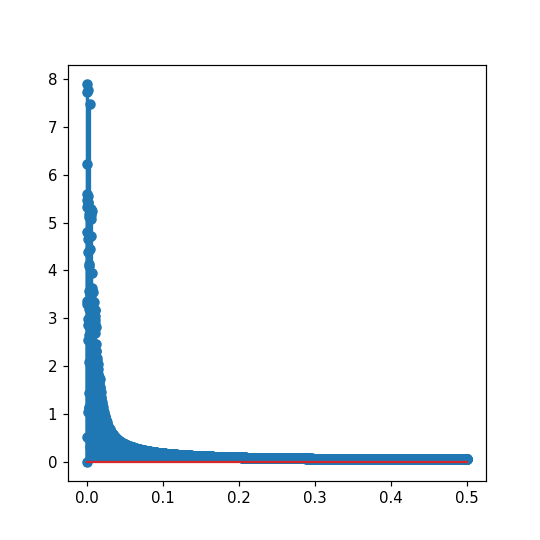

<StemContainer object of 3 artists>

In [49]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.stem(k2,coefM2,use_line_collection=True)

In [50]:
#Periodo
ii = np.argmax(np.abs(coef)) #Halla la frecuencia dominante
freqP = k2[ii]  #Frecuencia principal
T = 1/freqP
print(T)

800.0


<IPython.core.display.Javascript object>


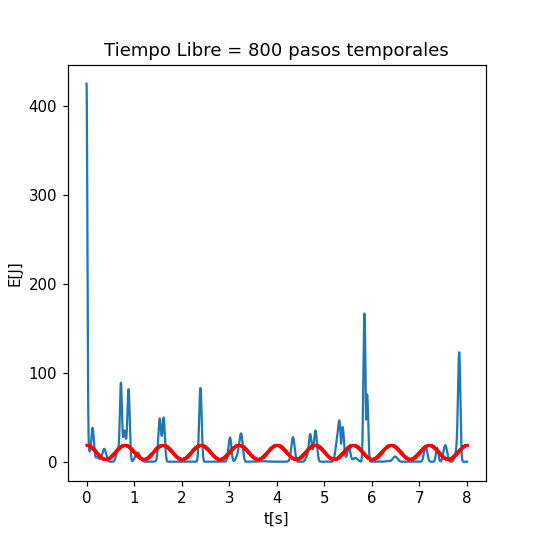

In [53]:
mask1 = k > freqP #Se limpian los datos correspondientes a frecuencias que no son la principal
mask2 = k < freqP
coef[mask1] = 0
coef[mask2] = 0 
NewSample = np.fft.ifft(2*coef) 

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel("t[s]")
ax.set_ylabel("E[J]")
ax.set_title("Tiempo Libre = 800 pasos temporales")
ax.plot(t, E, label = "Datos")
ax.plot(t, np.real(NewSample)+media,'.-',label='Freq Dominante', c = 'r', markersize = 1) #se suma la media 

In [71]:
cv = 1.5* 8.3145
k = 389.6
A = 0.01
l = 0.30
n = 1

C = k*A/(n*cv*l)

N = 5000
t = np.linspace(0.,100.,N)

r0 = np.array([-C*200, C*200])


In [106]:
def df(t,T1,T2):
    
    return np.array((-C*(T1-T2), C*(T1-T2)))

def GetRK4(df, r0, t, Nec, init = False, Npoints = 4):
    
    h = (t[-1] - t[0])/(len(t)-1)
    y = np.zeros((len(t), Nec))
    
    y[0] = r0
    
    if init == False:
        Npoints = len(t)
    

    for i in range(1,Npoints):
        
        k1 = df(t[i-1], y[i-1][0], y[i-1][1])
        print(k1)
        k2 = df(t[i-1] + 0.5*h, y[i-1][0] + 0.5*k1[0]*h, y[i-1][1] + 0.5*k1[0]*h)
        k3 = df(t[i-1] + 0.5*h, y[i-1][0] + 0.5*k2*h, y[i-1][1] + 0.5*k2*h )
        k4 = df(t[i-1] + h, y[i-1][0] + k3*h, y[i-1][1] + k3*h)
        
        print(y[i-1][0] + h*(k1 + 2*k2 + 2*k3 + k4)/6)
        y[i] = y[i-1][0] + h*(k1 + 2*k2 + 2*k3 + k4)/6
        
            
    
    
    return y

In [107]:
yrk4 = GetRK4(df,r0,t, 2, False,4)

[ 433.71114761 -433.71114761]
[ 433.71114761 -433.71114761]
[[[-207.82361708 -208.25732823]
  [-208.11275785 -208.54646899]]

 [[-207.96818746 -208.40189861]
  [-208.25732823 -208.69103938]]]


ValueError: could not broadcast input array from shape (2,2,2) into shape (2)